# Homework exercise 3
## Deadline: upload to Moodle by 7 June 18:00 h

__Please submit your homework either as a Jupyter Notebook or using .py files.__

If you use .py files, please also include a PDF containing the output of your code and your explanations. Either way, the code needs to be in a form that can be easily run on another computer.

__Name 1:__ Sebastian Ertner

__Name 2:__ Sebastian Krendl

__Name 3:__ Dushan Trajkovski


The name of the file that you upload should be named *Homework1_YourLastName_YourStudentID*.

Reminder: you are required to attend class on 26 May to earn points for this homework exercise unless you have a valid reason for your absence.

You are encouraged to work on this exercise in teams of up to three students. If any part of the questions is unclear, please ask on the Moodle forum.

#### APIs, NLP, ML


__Reddit__


The Reddit offers an API providing free access to up to 1000 submissions (i.e. posts), comments on those submissions, and some meta data. `PRAW` is a module that facilitates usage of the Reddit API, and it is recommended that you use it. It is documented at https://praw.readthedocs.io/en/latest/index.html and the Quick Start page should give you most of the information you need.

(If you would like to use more Reddit data, you may want to consider `PSAW`. You won't need it for this homework exercise, though it might be of interest if you'd like to use Reddit in your course project.)

Please note that using the Reddit API requires users to register. Feel free to use any temporary email address if you have any concerns with sharing your usual address with Reddit.

Please collect data for the top 1000 submissions and all the comments on those submissions for the subreddits 'wallstreetbets' and 'StockMarket'.

The goal will be to classify submissions, i.e., to predict which subreddit each submission belongs to. 

Write a class RedditClassifier that contains two object attributes: the categorical variable to be used in the classification (here: the subreddit) and a list (for now, since you have only encountered a binary classifier, of length 2) of values for that category (i.e. a list of the names of the two subreddits). The class should be derived from the Perceptron class from Chapter 7. It should contain a method that combines the preprocessing and the estimation.

The preprocessing should generate features that might help predict the category. Please don't use features such as the frequency of each word as we will take a look at appropriate ways of working with such information only in the next class. Possible features could be: length of title, number of comments, average sentence length, word length, number of sentences in the comments, shares of nouns, verbs, etc., number of stop words used compared to other words, etc.. Please add any other features that you think might be useful for this task but don't include features that are likely to perfectly predict the category (e.g. the author of a submission).

Please use this class to classify the submissions. Plot the percentage of submissions that are incorrectly classified in each epoch for different learning rates. Don't expect to achieve near-perfect predictions as the features you employ may not be able to easily distinguish between categories the way they did in the example in class.

# Solution

## Get data from Reddit API

In [2]:
import math
import praw
import pandas as pd

In [35]:
# function to get up to num_posts_limit posts form each of the subreddits "StockMarket" and "wallstreetbets"
# if hot_section is True, then takes data from 'hot', if False then from 'top'
def get_reddit_api_data(num_posts_limit, hot_section=True):
    #sign in to get the API

    reddit = praw.Reddit(
        client_id="",
        client_secret="",
        username="",
        password="",
        user_agent="",)

    #create empty lists for characteristics and text
    p_post_ID = []
    titles = []
    num_comments = []
    text = []
    upvotes = []
    subreddits = []
    c_error = []   # to later filter out posts that had an error when accessing comments

    c_post_ID = []
    parent_ID = []
    comment_ID = []
    body = []  # comment text

    # for progress feedback
    i = 0
    prog_upd = int(math.sqrt(2*num_posts_limit))
    print('Progress:   0%', end='\r')

    for sub in ["StockMarket", "wallstreetbets"]:


        #choose the subreddit
        subreddit = reddit.subreddit(sub)

        #get posts up to limit from hot section of the subreddit, or else from top
        if hot_section:
            sub_posts = subreddit.hot(limit=num_posts_limit)
        else:
            sub_posts = subreddit.top(limit=num_posts_limit)

        #loop over submissions on the board, append the lists with the characteristics
        for submission in sub_posts:
            if not submission.stickied:
                p_post_ID.append(submission.id)
                titles.append(submission.title)
                num_comments.append(submission.num_comments)
                upvotes.append(submission.ups)
                text.append(submission.selftext)
                subreddits.append(sub)

                #avoid error when not all comments are loaded in at first and get a 
                #list of all comments to loop over   
                try:
                    submission.comments.replace_more()
                    comments = submission.comments.list()
                    for comment in comments:
                        c_post_ID.append(submission.id)
                        parent_ID.append(comment.parent())
                        comment_ID.append(comment.id)
                        body.append(comment.body)
                    c_error.append(0)
                except:
                    c_error.append(1)

            # progress feedback
            i += 1
            if i%prog_upd == 0:
                print(f'Progress: {int(i/2/num_posts_limit*100):3d}%', end='\r')
    print('Progress: 100%')

    #merge lists to dataframe for posts and comments
    df_posts = pd.DataFrame({'post ID': p_post_ID, 'title': titles, 'num comments': num_comments, 
                             'upvotes': upvotes, 'text': text, 'subreddit': subreddits, 'comment error': c_error})
    df_comments = pd.DataFrame({'post ID': c_post_ID, 'parent ID': parent_ID,'comment ID': comment_ID,'comment text': body})

    return df_posts, df_comments

We get up to 1000 posts form the hot section of the subreddits.

In [77]:
df_posts, df_comments = get_reddit_api_data(1000, hot_section=True)

Progress: 100%


Use this to load existing data instead:

In [119]:
# df_posts = pd.read_csv("data/posts.csv")
# df_comments = pd.read_csv("data/comments.csv")

Save data

In [120]:
import os

dir_save="data"
try:
    os.mkdir(dir_save)
    print("directory created")
except:
    print("directory exists")

directory exists


In [121]:
df_posts.to_csv(dir_save+"/posts.csv", index=False)
df_comments.to_csv(dir_save+"/comments.csv", index=False)

Take a look at the data

In [122]:
num_posts = len(df_posts)
num_posts

625

In [123]:
num_sm_posts = sum(df_posts['subreddit'] == 'StockMarket')
num_sm_posts

449

In [124]:
num_wsb_posts = sum(df_posts['subreddit'] == 'wallstreetbets')
num_wsb_posts

176

Unfortunately not a lot of posts and from wallstreetbets only half as many as from StockMarket.

In [125]:
df_posts.head()

,post ID,title,num comments,upvotes,text,subreddit,comment error
0,nual1x,Most Anticipated Earnings For This Week! Keep ...,31,214,NaN,StockMarket,0
1,nucxl4,Adding Fuel to the Fire,7,153,NaN,StockMarket,0
2,ntzxpo,"TOMORROW WILL BE A DAY LIKE NO OTHER, IT WILL ...",72,348,NaN,StockMarket,0
3,nu7mpz,Next year's HP12C financial calculator to come...,2,52,NaN,StockMarket,0
4,ntm150,Most discussed stocks of last week! what are y...,536,1526,NaN,StockMarket,0


In [126]:
df_posts[num_sm_posts:num_sm_posts+5]

,post ID,title,num comments,upvotes,text,subreddit,comment error
449,nu5msl,$BB vs. hedge fund anime,575,8077,NaN,wallstreetbets,0
450,ntzimi,Chad Money: Episode 3,826,15268,NaN,wallstreetbets,0
451,nu2vrg,Wall Street’s top brokers are quietly tighteni...,225,1971,Great news for retail. Now the hedge funds can...,wallstreetbets,0
452,nufjik,$BB - Blackberry to participate in upcoming In...,23,127,Blackberry will be discussing the latest devel...,wallstreetbets,0
453,nudcrm,To the guy who recommended Wendy's stock($WEN)...,118,121,"Stick with me here.\n\n[This, This right here....",wallstreetbets,0


In [127]:
len(df_comments)

47108

In [128]:
df_comments.head()

,post ID,parent ID,comment ID,comment text
0,nual1x,nual1x,h0we78s,Gamestop earnings 💪
1,nual1x,nual1x,h0wod33,"Can't Stop, Won't Stop"
2,nual1x,nual1x,h0wintf,Heres to hoping for better blackberry juice!!!!!
3,nual1x,nual1x,h0wi3p0,Looking forward to another quarter of terrible...
4,nual1x,nual1x,h0x16iy,"ASO tomorrow has to be solid, right?"


In [129]:
df_comments[num_sm_posts:num_sm_posts+5]

,post ID,parent ID,comment ID,comment text
449,ntm150,h0uishu,h0up450,We will see if this point stand or not in this...
450,ntm150,h0tehnw,h0tgek6,I had a rough time holding GameStop I bought i...
451,ntm150,h0tizdx,h0tk3a2,utter horseshit
452,ntm150,h0tizdx,h0u0bku,"The market has went up 10,200% in the last 50 ..."
453,ntm150,h0unwr7,h0urcnu,Is there a certain amount they need to deliver...


Split data into training and test data.  
Since we don't have a lot of observations we only take 15 from each subreddit for testing data, so results might not be too robust. 

In [130]:
df_posts_train = pd.concat([df_posts[:num_sm_posts-15], df_posts[num_sm_posts:-15]])
df_posts_test = pd.concat([df_posts[num_sm_posts-15:num_sm_posts], df_posts[-15:]])
print(len(df_posts_train),len(df_posts_test),len(df_posts_train)+len(df_posts_test))

595 30 625


## RedditClassifier class definition

features:
* derived from Perceptron class
* object attributes
    * categorical variable
    * values for categorical variable
* methods
    * preprocessing
    * estimation

In [131]:
import matplotlib.pyplot as plt
import nltk
import numpy as np

For sentence tokenization later

In [132]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ert\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Perceptron classifier taken directly from course materials

In [133]:
class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

RedditClassifier derived from Perceptron classifier:

In [134]:
class RedditClassifier(Perceptron):

    def __init__(self, cat_var, cat_vals, eta=0.01, n_iter=50, random_state=1):
        Perceptron.__init__(self, eta, n_iter, random_state)
        self.cat_var = cat_var   # categorical variable used in the classification
        self.cat_vals = cat_vals # possible values for this variable

    def preprocess(self, df_posts, df_comments):
        ## copying relevant columns from input data frame for manipulation:
        X = df_posts[['post ID','title','upvotes','num comments','comment error']].copy()
        X = X[X['comment error'] == 0]  # drop all rows where there was an error while retrieving the comments
        
        ## adjusting relevant features and categorical variables:            
        X['title len'] = X['title'].apply(len)  # instead of title only take length of title
                                                # upvotes and num comments are already in right form
        
        ## NLP
        space_tokenizer = nltk.tokenize.SpaceTokenizer()
        for index, post in X.iterrows():
            avg_sent_lens = [] # list of average sentence lenght within each comment of the post
            avg_sent_nums = [] # etc.
            avg_word_lens = []
            avg_word_nums = []
            post_comments = df_comments[df_comments['post ID'] == post['post ID']]
            if len(post_comments) > 0:  # check if there are any comments
                for _, comment in post_comments.iterrows():
                    # average sentence length
                    sentence_tokens = nltk.sent_tokenize(comment['comment text'])
                    sentence_lens = np.array([len(sentence) for sentence in sentence_tokens])
                    avg_sent_lens.append(sentence_lens.mean())
                    # average number of sentences
                    avg_sent_nums.append(len(sentence_lens))
                    # average word length
                    word_tokens = space_tokenizer.tokenize(comment['comment text'])
                    word_lens = np.array([len(word) for word in word_tokens])
                    avg_word_lens.append(word_lens.mean())
                    # average number of words
                    avg_word_nums.append(len(word_lens))
            else:
                avg_sent_lens.append(0)
                avg_sent_nums.append(0)
                avg_word_lens.append(0)
                avg_word_nums.append(0)
            X.loc[index, 'avg sentence length'] = np.array(avg_sent_lens).mean() # average sentence lenght in all sentences
                                                                                 # of all comments on this post
            X.loc[index, 'avg sentence number'] = np.array(avg_sent_nums).mean()
            X.loc[index, 'avg word length'] = np.array(avg_word_lens).mean()
            X.loc[index, 'avg word number'] = np.array(avg_word_nums).mean()
            
        X = X[['title len','upvotes','num comments','avg sentence length',
               'avg sentence number','avg word length','avg word number']].values # select only the columns we need
        y = df_posts[[self.cat_var]].values  # categorical variable as specified in object instantiation
        y = np.where(y == self.cat_vals[0], 1, -1)
        
        # for plotting
        self.num_obs_ = len(y)  # number of observations after preprocessing

        return X, y
        
    # a simpler preprocessing method that only uses the submission/posts 
    # data and not the comments data for categorization
    def preprocess_simple(self, df_posts):
        ## copying relevant columns from input data frame for manipulation:
        X = df_posts[['title','upvotes','num comments','comment error']].copy()
        X = X[X['comment error'] == 0]  # drop all rows where there was an error while retrieving the comments
        
        ## adjusting relevant features and categorical variables:
        X['title len'] = X['title'].apply(len)  # instead of title only take length of title
        
        X = X[['title len','upvotes','num comments']].values # select only the columns we need
        y = df_posts[[self.cat_var]].values  # categorical variable as specified in object instantiation
        y = np.where(y == self.cat_vals[0], 1, -1)
        
        # for plotting
        self.num_obs_ = len(y)  # number of observations after preprocessing
        
        return X, y
    
    def prep_and_fit(self, df_posts, df_comments):
        X, y = self.preprocess(df_posts, df_comments)
        self.fit(X, y)

## Classify data

In [135]:
sub_classifier = RedditClassifier('subreddit', ['StockMarket', 'wallstreetbets'], n_iter=100, random_state=42)

We can take a look at the correlation between features (for the full data set):

In [136]:
X, y = sub_classifier.preprocess_simple(df_posts)

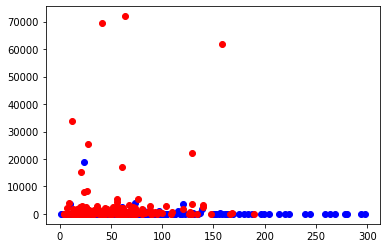

In [137]:
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(X[:num_sm_posts,0],X[:num_sm_posts,1], color='blue')
plt.scatter(X[num_sm_posts:,0],X[num_sm_posts:,1], color='red')

Classification of the obtained data:

In [138]:
sub_classifier.prep_and_fit(df_posts_train, df_comments)

In [139]:
sub_classifier.errors_[-5:]

[30, 21, 25, 29, 28]

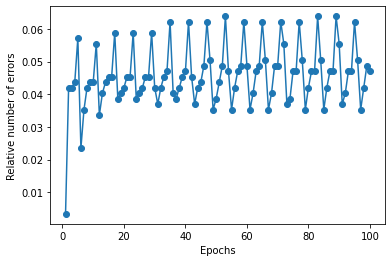

In [140]:
plt.plot(range(1, len(sub_classifier.errors_) + 1), [x/sub_classifier.num_obs_ for x in sub_classifier.errors_], marker='o')
plt.xlabel('Epochs')
plt.ylabel('Relative number of errors')
plt.show()

We see that the accuracy is around 95%.

In [141]:
sub_classifier.w_

array([   0.62496714,   31.05861736, -266.61352311, -157.7847697 ,
         33.26704411,    3.99607428,    0.60962742,  -14.204572  ])

Since there are only half as many posts in "hot" for wallstreetbets compared to StockMarket, we repeat the procedure with an equal amount of observations for each to see if results change.

In [142]:
sub_classifier_eq = RedditClassifier('subreddit', ['StockMarket', 'wallstreetbets'], n_iter=100, random_state=42)

In [143]:
df_posts_equal = pd.concat([df_posts_train[:num_wsb_posts-15],df_posts_train[-num_wsb_posts+15:]])
sub_classifier_eq.prep_and_fit(df_posts_equal, df_comments)

In [144]:
sub_classifier_eq.errors_[-5:]

[24, 21, 25, 28, 29]

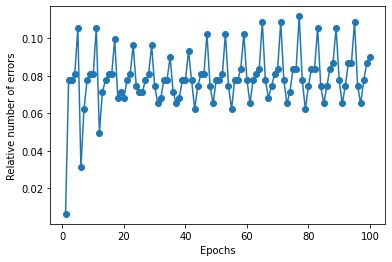

In [145]:
plt.plot(range(1, len(sub_classifier_eq.errors_) + 1), [x/sub_classifier_eq.num_obs_ for x in sub_classifier_eq.errors_], marker='o')
plt.xlabel('Epochs')
plt.ylabel('Relative number of errors')
plt.show()

We see that the accuracy is a bit worse.

In [146]:
sub_classifier_eq.w_

array([   0.40496714,   42.23861736, -269.89352311, -248.2047697 ,
         53.22898262,    3.27179238,    1.68869609,  -24.15135061])

We can also try the simpler preprocessing method and compare results:

In [147]:
sub_classifier_simp = RedditClassifier('subreddit', ['StockMarket', 'wallstreetbets'], n_iter=100, random_state=42)

In [148]:
X, y = sub_classifier_simp.preprocess_simple(df_posts_train)
sub_classifier_simp.fit(X, y)

In [149]:
sub_classifier_simp.errors_[-5:]

[34, 22, 27, 27, 29]

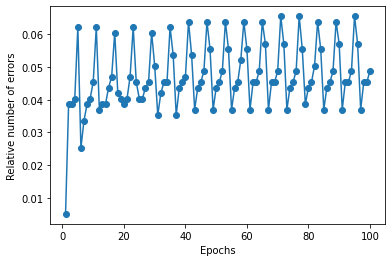

In [150]:
plt.plot(range(1, len(sub_classifier_simp.errors_) + 1), [x/sub_classifier_simp.num_obs_ for x in sub_classifier_simp.errors_], marker='o')
plt.xlabel('Epochs')
plt.ylabel('Relative number of errors')
plt.show()

The accuracy is still around 95%.

In [151]:
sub_classifier_simp.w_

array([   9.36496714,   34.83861736, -283.13352311, -104.9247697 ])

## Test the Classifier

We preprocess the testing data as well

In [152]:
X_test, y_test = sub_classifier.preprocess(df_posts_test, df_comments)

Now predict categories using the trained model and evaluate accuracy

In [153]:
y_pred = sub_classifier.predict(X_test)
correct = 0
for i in range(sub_classifier.num_obs_):
    if y_pred[i] == y_test[i]:
        correct += 1
print(f'Prediction accuracy: {int(correct/sub_classifier.num_obs_*100)}%')

Prediction accuracy: 76%


So the prediction accuracy is significantly lower, but as said before this result might not be robust due to the small data set.